In [21]:
import jax.numpy as np
from jax import grad
from jax import vmap
from functools import partial
from jax import jit
from jax import random
from jax.experimental import stax
from jax.example_libraries.stax import Conv,Dense, MaxPool, Relu, LogSoftmax, Flatten
import matplotlib.pyplot as plt
import numpy as onp
from jax.example_libraries import optimizers
from jax.tree_util import tree_multimap

In [54]:
net_init, net_apply= stax.serial(Dense(40),Relu,
                                Dense(40),Relu,
                                Dense(1)
                                )
in_shape=(-1,1,)
rng=random.PRNGKey(0)
out_shape, net_params = net_init(rng,in_shape)

In [55]:
def loss(params, inputs, targets):
    predictions = net_apply(params,inputs)
    return np.mean((targets-predictions)**2)

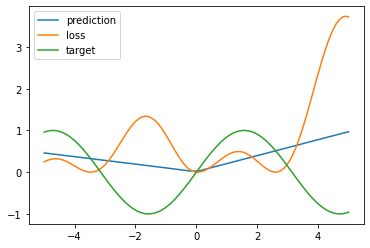

In [18]:
xrange_inputs = np.linspace(-5,5,100).reshape((100,1))
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply,net_params))(xrange_inputs)
losses= vmap(partial(loss,net_params))(xrange_inputs,targets)
plt.plot(xrange_inputs,predictions,label='prediction')
plt.plot(xrange_inputs,losses,label='loss')
plt.plot(xrange_inputs,targets,label='target')
plt.legend()

In [28]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(net_params)

@jit
def step(i,opt_state,x1,y1):
    p=get_params(opt_state)
    g= grad(loss)(p,x1,y1)
    return opt_update(i,g,opt_state)

for i in range(500):
    opt_state= step(i,opt_state, xrange_inputs, targets)
    
net_params = get_params(opt_state)

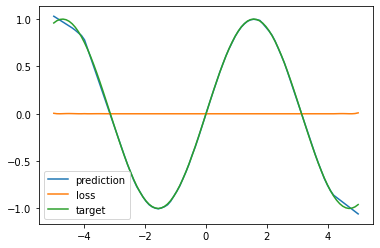

In [29]:
targets= np.sin(xrange_inputs)
predictions= vmap(partial(net_apply,net_params))(xrange_inputs)
losses= vmap(partial(loss,net_params))(xrange_inputs,targets)
plt.plot(xrange_inputs,predictions,label='prediction')
plt.plot(xrange_inputs,losses,label='loss')
plt.plot(xrange_inputs,targets,label='target')
plt.legend()

In [30]:
g = lambda x, y: np.square(x)+y
x0=2.
y0=1.
print('grad(g)(x0)={}'.format(grad(g)(x0,y0)))
print('x0-grad(g)(x0)={}'.format(x0-grad(g)(x0,y0)))
def maml_objective(x,y):
    return g(x-grad(g)(x,y),y)
print('maml_objective(x,y)={}'.format(maml_objective(x0,y0)))
print('x0-maml_objective(x,y)={}'.format(x0-grad(maml_objective)(x0,y0)))


grad(g)(x0)=4.0
x0-grad(g)(x0)=-2.0
maml_objective(x,y)=5.0
x0-maml_objective(x,y)=-2.0


In [32]:
x1= xrange_inputs
y1=targets
x2,y2=np.array([0.]),np.array([0.])
maml_loss(net_params,x1,y1,x2,y2)

DeviceArray(5.4101354e-05, dtype=float32)

In [56]:
alpha=.1
def inner_update(p,x1,y1):
    grads= grad(loss)(p,x1,y1)
    inner_sgd_fn= lambda g, state: (state-alpha*g)
    return tree_multimap(inner_sgd_fn,grads,p)

def maml_loss(p,x1,y1,x2,y2):
    p2= inner_update(p,x1,y1)
    return loss(p2,x2,y2)

In [57]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-3)
out_shape, net_params= net_init(rng,in_shape)
opt_state = opt_init(net_params)

@jit
def step(i,opt_state,x1,y1,x2,y2):
    p=get_params(opt_state)
    g= grad(maml_loss)(p,x1,y1,x2,y2)
    l=maml_loss(p,x1,y1,x2,y2)
    return opt_update(i,g,opt_state),l

In [58]:
K=20

np_maml_loss=[]
for i in range(10000):
    A=onp.random.uniform(0.1,.5)
    phase= onp.random.uniform(0.,np.pi)
    #inner loop
    x1=onp.random.uniform(-5.,5.,size=(K,1))
    y1=A*onp.sin(x1+ phase)
    #outer loop
    x2= onp.random.uniform(-5.,5.)
    y2=A*onp.sin(x2+phase)
    
    opt_state,l= step(i,opt_state, x1,y1,x2,y2)
    np_maml_loss.append(l)
    if i%1000==0:
        print(i)
    
net_params = get_params(opt_state)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


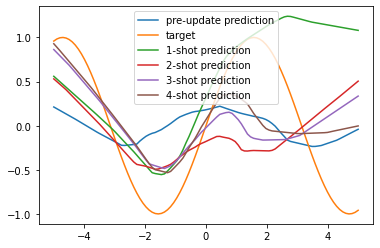

In [59]:
targets= np.sin(xrange_inputs)
predictions= vmap(partial(net_apply,net_params))(xrange_inputs)
plt.plot(xrange_inputs,predictions,label='pre-update prediction')
plt.plot(xrange_inputs,targets,label='target')

x1=onp.random.uniform(-5.,5.,size=(K,1))
y1= 1. * onp.sin(x1+0.)

for i in range(1,5):
    net_params= inner_update(net_params,x1,y1)
    predictions = vmap(partial(net_apply,net_params))(xrange_inputs)
    plt.plot(xrange_inputs,predictions,label='{}-shot prediction'.format(i))

plt.legend()    